# Model parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) dynamical system

We show how to use cd-dynamax to estimate the parameters of a continuous-discrete (non-linear) dynamical system



## Preliminaries

### Code Setup

In [1]:
# Main imports
import sys
from itertools import count

# Import jax and utils
from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from jax import jit, vmap

# Additional, custom codebase
sys.path.append("../..")
sys.path.append("../../..")

# Our own custom src codebase
# continuous-discrete nonlinear Gaussian SSM codebase
from utils.plotting_utils import *
# CD-Nonlinear Gaussian models
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *

# Plotting
import matplotlib
%matplotlib inline
# Our own custom plotting codebase
from utils.plotting_utils import *
from lorenz_plotting import *
# Feel free to change the default figure size
#matplotlib.rcParams['figure.figsize'] = [16, 9]


Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 430, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/iurteaga/miniconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic z

# TODO: define all functions here, move them to appropriate utils files

In [2]:
# Function to generate irregular measurement time-points
# uniformly sampled from a time domain $[0,T_total]$
def generate_irregular_t_emissions(
        T_total: Float,
        num_timesteps: int,
        T_filter: Optional[Float] = None,
        key=jr.PRNGKey(0)
    ) -> Tuple[Array, Array, Array, int, int, int]:
    """
    Generate random time points for measurements, filtering and forecasting.
    sampled uniformly from a time domain $[0,T_total]$
    where user can specificy filtering and forecasting intervals

    Args:
    - T_total: Float, total time length
    - num_timesteps: int, total number of time points
    - T_filter: Optional[Float], end of filtering time
    - key: jr.PRNGKey, random key

    Returns:
    - t_emissions: Array, time points for measurements
    - t_filter: Array, time points for filtering
    - t_forecast: Array, time points for forecasting
    - num_timesteps: int, total number of time points
    - num_timesteps_filter: int, number of time points for filtering
    - num_timesteps_forecast: int, number of time points for forecasting
    """
    
    # Generate random num_timesteps time points
    t_emissions = jnp.array(
        sorted(
            jr.uniform(
                key,
                (num_timesteps, 1),
                minval=0,
                maxval=T_total
            )
        )
    )
    # drop duplicates, and format as column vector
    t_emissions = jnp.unique(t_emissions)[:, None]

    # If interested, separate filtering and forecasting time points
    if T_filter is not None:
        t_filter = t_emissions[t_emissions <= T_filter, None]
        t_forecast = t_emissions[t_emissions > T_filter, None]
    else:
        t_filter = t_emissions
        t_forecast = None

    # Count number of time points
    num_timesteps = len(t_emissions)
    num_timesteps_filter = len(t_filter)
    num_timesteps_forecast = len(t_forecast) if t_forecast is not None else 0
    
    # Return time points and counts
    return t_emissions, t_filter, t_forecast, num_timesteps, num_timesteps_filter, num_timesteps_forecast

In [3]:
# For distributional forecasting, import MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

# Function to filter and forecast, based on model with given parameters
def filter_and_forecast(
    model_params,
    filter_hyperparams,
    t_emissions,
    emissions,
    T0=50,
    T_filter_end=70,
    T_forecast_end=100,
    ):

    # Figure out the time points for filtering
    start_idx_filter = jnp.where(t_emissions >= T0)[0][0]
    stop_idx_filter = jnp.where(t_emissions >= T_filter_end)[0][0]

    # Figure out the time points for forecasting
    start_idx_forecast = jnp.where(t_emissions >= T_filter_end)[0][0]
    stop_idx_forecast = jnp.where(t_emissions >= T_forecast_end)[0][0]

    # Run filter on filtering time points
    filtered = cdnlgssm_filter(
        params=model_params,
        emissions=emissions[start_idx_filter:stop_idx_filter],
        t_emissions=t_emissions[start_idx_filter:stop_idx_filter],
        hyperparams=filter_hyperparams,
    )

    # Initialize forecast with last filtered state
    init_time = t_emissions[stop_idx_filter]
    init_forecast = MVN(filtered.filtered_means[-1, :], filtered.filtered_covariances[-1, :])

    forecasted = cdnlgssm_forecast(
        params=model_params,
        init_forecast=init_forecast,
        t_init=init_time,
        t_forecast=t_emissions[start_idx_forecast:stop_idx_forecast],
        hyperparams=filter_hyperparams,
    )

    return filtered, forecasted, start_idx_filter, stop_idx_filter, start_idx_forecast, stop_idx_forecast

In [4]:
def plot_param_distributions(
    samples,
    true,
    sgd,
    name="",
    burn_in_frac=0.5,
    skip_if_not_trainable=True,
    trainable=True,
    triangle_plot=True,
    box_plot=True,
):
    """
    Plots N_params horizontal box plots for the given N_params x N_samples matrix or a triangle plot of bivariate densities.

    Parameters:
    - samples: N_params x N_samples matrix of parameter samples.
    - true: N_params array of true parameter values.
    - sgd: N_params array of SGD estimates.
    - name: Name of the parameter set.
    - burn_in_frac: Fraction of samples to discard as burn-in.
    - skip_if_not_trainable: If True and trainable is True, skip plotting.
    - trainable: Indicates if the parameter is trainable.
    - triangle_plot: If True, plots a triangle plot with bivariate densities and histograms.
    - box_plot: If True, plots box plots for parameter distributions.

    Returns:
    - A matplotlib figure with N_params horizontal box plots or a triangle plot.
    """
    if skip_if_not_trainable and not trainable:
        return

    if trainable:
        name += " (trainable)"

    # apply burn-in
    burn_in = int(burn_in_frac * samples.shape[1])
    samples = samples[:, burn_in:]

    if triangle_plot:
        import seaborn as sns
        import pandas as pd
        import matplotlib.pyplot as plt

        # Create a DataFrame from the samples
        df = pd.DataFrame(samples.T, columns=["Parameter {}".format(i + 1) for i in range(samples.shape[0])])

        # Plot pairplot with histograms on the diagonal
        g = sns.pairplot(df, kind="kde", diag_kind="hist")
        g.fig.suptitle("{} Triangle Plot with Bivariate Densities".format(name), y=1.02)

        # Add SGD and ground truth values to the plot
        for i, param in enumerate(df.columns):
            g.axes[i, i].axvline(true[i], color="red", linestyle="--", label="Ground Truth")
            g.axes[i, i].axvline(sgd[i], color="magenta", linestyle="--", label="SGD Estimate")
            for j in range(i):
                g.axes[i, j].scatter(true[j], true[i], color="red", marker="x", s=100, zorder=4)
                g.axes[i, j].scatter(sgd[j], sgd[i], color="magenta", marker="o", s=100, zorder=3)
                g.axes[j, i].set_visible(False)  # Hide the upper right axes
        handles, labels = g.axes[0, 0].get_legend_handles_labels()
        g.fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1, 0.95))  # Add legend to the bottom-left plot
        plt.show()
    if box_plot:
        N_params = samples.shape[0]
        fig, ax = plt.subplots(figsize=(10, N_params * 2))  # Adjust figure size based on number of parameters

        # Create box plots
        ax.boxplot(samples, vert=False, patch_artist=True)

        # Set the y-axis labels to show parameter indices
        ax.set_yticks(range(1, N_params + 1))
        ax.set_yticklabels(["Parameter {}".format(i + 1) for i in range(N_params)])

        # Plot ground truth and estimates
        ax.scatter(
            sgd, range(1, N_params + 1), color="magenta", marker="o", s=100, label="Initial SGD Estimate", zorder=3
        )
        ax.scatter(true, range(1, N_params + 1), color="red", marker="x", s=100, label="Ground Truth", zorder=4)

        plt.xlabel("Value")
        plt.ylabel("Parameters")
        plt.title("{} Parameter Distributions".format(name))
        plt.grid(True)
        plt.legend()
        plt.show()

In [5]:
def plot_all(param_samples, burn_in_frac=0.5, skip_if_not_trainable=True, triangle_plot=True, box_plot=True):
    """
    Plots the posterior distributions of all parameters.
    Burn-in is removed from the samples.
    """
    plot_param_distributions(
        param_samples.initial.mean.params.T,
        true_params.initial.mean.params,
        fitted_params.initial.mean.params,
        name="Initial mean",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.initial.mean.params.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )
    plot_param_distributions(
        param_samples.initial.cov.params.reshape(param_samples.initial.cov.params.shape[0], -1).T,
        true_params.initial.cov.params.flatten(),
        fitted_params.initial.cov.params.flatten(),
        name="Initial cov",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.initial.cov.params.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.params.reshape(param_samples.dynamics.drift.params.shape[0], -1).T,
        true_params.dynamics.drift.params,
        fitted_params.dynamics.drift.params,
        name="Dynamics drift parameters",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.dynamics.drift.params.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_cov.params.reshape(param_samples.dynamics.diffusion_cov.params.shape[0], -1).T,
        true_params.dynamics.diffusion_cov.params.flatten(),
        fitted_params.dynamics.diffusion_cov.params.flatten(),
        name="Dynamics diffusion cov",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.dynamics.diffusion_cov.params.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_coefficient.params.reshape(
            param_samples.dynamics.diffusion_coefficient.params.shape[0], -1
        ).T,
        true_params.dynamics.diffusion_coefficient.params.flatten(),
        fitted_params.dynamics.diffusion_coefficient.params.flatten(),
        name="Dynamics diffusion coefficient",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.dynamics.diffusion_coefficient.params.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.weights.reshape(
            param_samples.emissions.emission_function.weights.shape[0], -1
        ).T,
        true_params.emissions.emission_function.weights.flatten(),
        fitted_params.emissions.emission_function.weights.flatten(),
        name="Emissions function weights",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.emissions.emission_function.weights.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.bias.reshape(
            param_samples.emissions.emission_function.bias.shape[0], -1
        ).T,
        true_params.emissions.emission_function.bias.flatten(),
        fitted_params.emissions.emission_function.bias.flatten(),
        name="Emissions function bias",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.emissions.emission_function.bias.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )
    plot_param_distributions(
        param_samples.emissions.emission_cov.params.reshape(param_samples.emissions.emission_cov.params.shape[0], -1).T,
        true_params.emissions.emission_cov.params.flatten(),
        fitted_params.emissions.emission_cov.params.flatten(),
        name="Emissions cov",
        burn_in_frac=burn_in_frac,
        skip_if_not_trainable=skip_if_not_trainable,
        trainable=learnable_props.emissions.emission_cov.params.trainable,
        triangle_plot=triangle_plot,
        box_plot=box_plot,
    )


# Generate synthetic data

We generate data from a Lorenz 63 system, from dynamics with the following stochastic differential equations:
\begin{align*}
\frac{d x}{d t} &= a(y-x) + \sigma w_x(t) \\
\frac{d y}{d t} &= x(b-z) - y + \sigma w_y(t) \\
\frac{d z}{d t} &= xy - cz + \sigma w_z(t),
\end{align*}

With parameters $a=10, b=28, c=8/3$, the system gives rise to chaotic behavior, and we choose $\sigma=0.1$ for light diffusion.

To generate data, we numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).


We assume the observation model is
\begin{align*}
y(t) &= H x(t) + r(t) \\
r(t) &\sim N(0,R),
\end{align*}
where we choose $R=I$. 

Namely, with H=I, we have full observability, with noisy observations, sampled at irregular time intervals.

### True, data-generating model definition

In [6]:
## Main settings
state_dim = 3
emission_dim = 3

# Define a custom drift model, inherited from LearnableFunction
class lorenz63_drift(LearnableFunction):
    params: Union[Float[Array, "state_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):
        foo = jnp.array(
            [
                self.params[0] * (x[1] - x[0]),
                self.params[1] * x[0] - x[1] - x[0] * x[2],
                -self.params[2] * x[2] + x[0] * x[1],
            ]
        )
        return foo

# Define the true parameters of the drift function
true_l63_drift_params = jnp.array([10.0, 28.0, 8 / 3])
# And the corresponding Lorenz 63 system
true_drift = {
    "params": lorenz63_drift(
        params=true_l63_drift_params
    ),
    "props": lorenz63_drift(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true parameters of the diffusion function
true_diffusion_coefficient_param = 0.1
true_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties()
    ),
}

# Define the true parameters of the emission function
# Full observability
H=jnp.eye(emission_dim,state_dim)
true_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(),
        bias=ParameterProperties()
    ),
}

# Define the true parameters of the emission covariance
R=jnp.eye(emission_dim)
true_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the true initial mean and covariance
true_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties()
    ),
}

true_initial_cov_param = 10.0
true_initial_cov = {
    "params": LearnableMatrix(
        params=true_initial_cov_param*jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            constrainer=RealToPSDBijector()
        )
    ),
}

# Concatenate all parameters in dictionary, for later easy use
all_true_params = {
    'initial_mean': true_initial_mean,
    'initial_cov': true_initial_cov,
    'dynamics_drift': true_drift,
    'dynamics_diffusion_coefficient': true_diffusion_coefficient,
    'dynamics_diffusion_cov': true_diffusion_cov,
    'dynamics_approx_order': 2., # Check on this later
    'emission_function': true_emission,
    'emission_cov': true_emission_cov,
}

### Simulation set-up

In [8]:
# Set up seed for simulation
keys = map(jr.PRNGKey, count())

# Simulation parameters
T_filter = 40
T_total = 50
num_timesteps_total = int(T_total*100)

# Generate time points for measurements, filtering and forecasting
# We will generate different train and test sets

## Train set
t_emissions_train, t_filter_train, t_forecast_train, \
    num_timesteps_train, num_timesteps_filter_train, num_timesteps_forecast_train= \
    generate_irregular_t_emissions(
        T_total=T_total,
        num_timesteps=num_timesteps_total,
        T_filter=T_filter,
        key=next(keys)
    )

## Test set
t_emissions_test, t_filter_test, t_forecast_test, \
    num_timesteps_test, num_timesteps_filter_test, num_timesteps_forecast_test= \
    generate_irregular_t_emissions(
        T_total=T_total,
        num_timesteps=num_timesteps_total,
        T_filter=T_filter,
        key=next(keys)
    )

### Model creation: object instantiation

In [9]:
# Create CD-NLGSSM model
true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(
    next(keys),
    **all_true_params
)

### Simulate data: sample from model

In [10]:
# sample true states and emissions from defined true model.
# Using transition_type="path" to solve the dynamics SDE.

## Train set
true_states_train, true_emissions_train = true_model.sample(
    true_params,
    next(keys),
    num_timesteps_train,
    t_emissions_train,
    transition_type="path" # uses the Euler-Maruyama method
)

## Test set
true_states_test, true_emissions_test = true_model.sample(
    true_params,
    next(keys),
    num_timesteps_test,
    t_emissions_test,
    transition_type="path" # uses the Euler-Maruyama method
)

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.


### Plot generated data

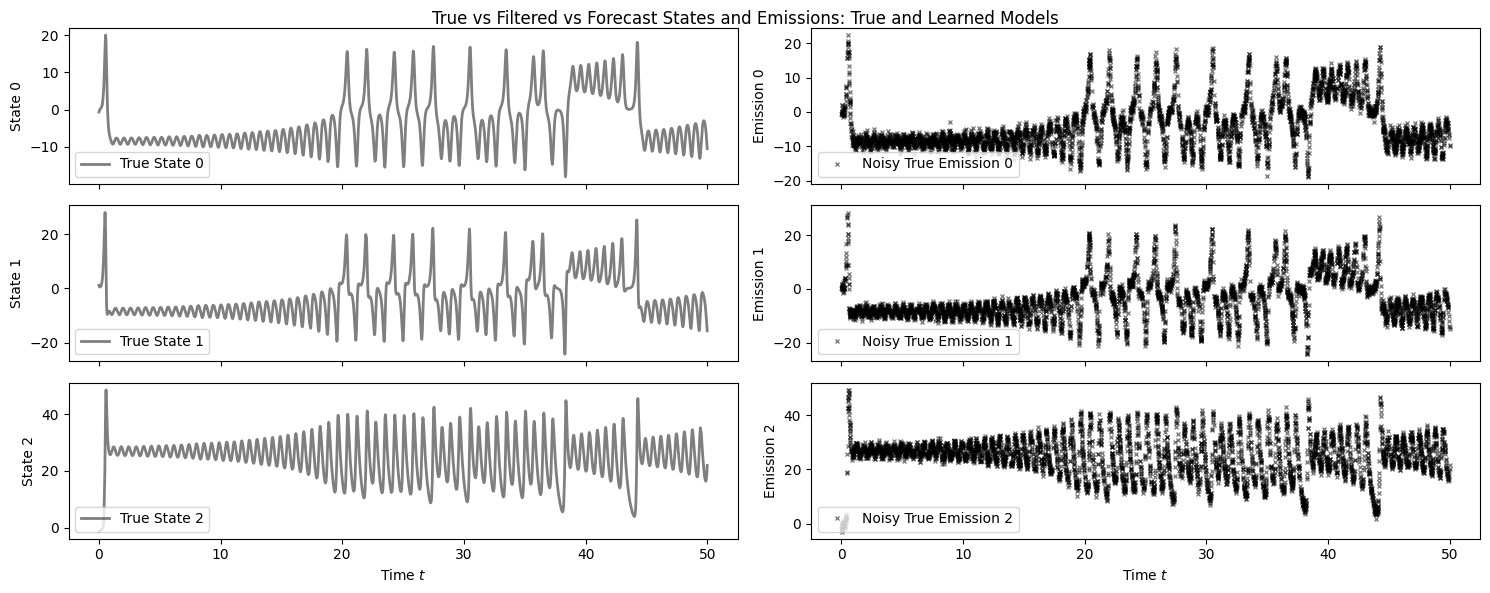

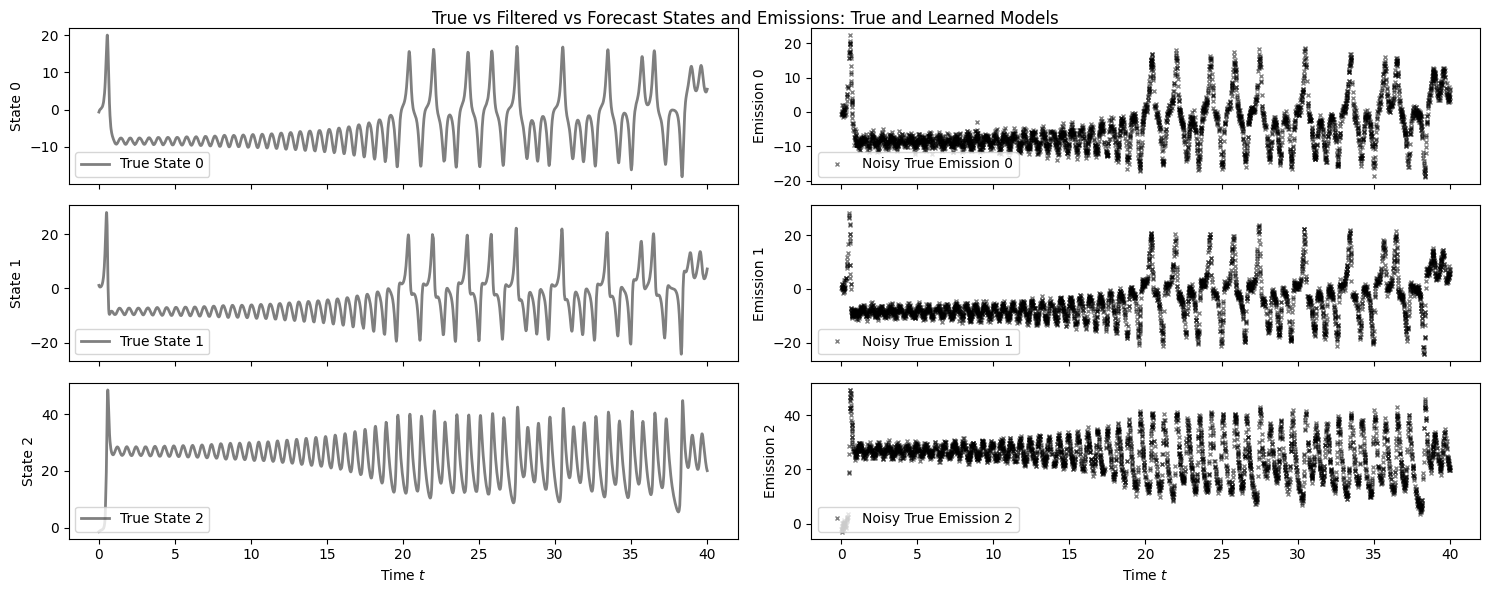

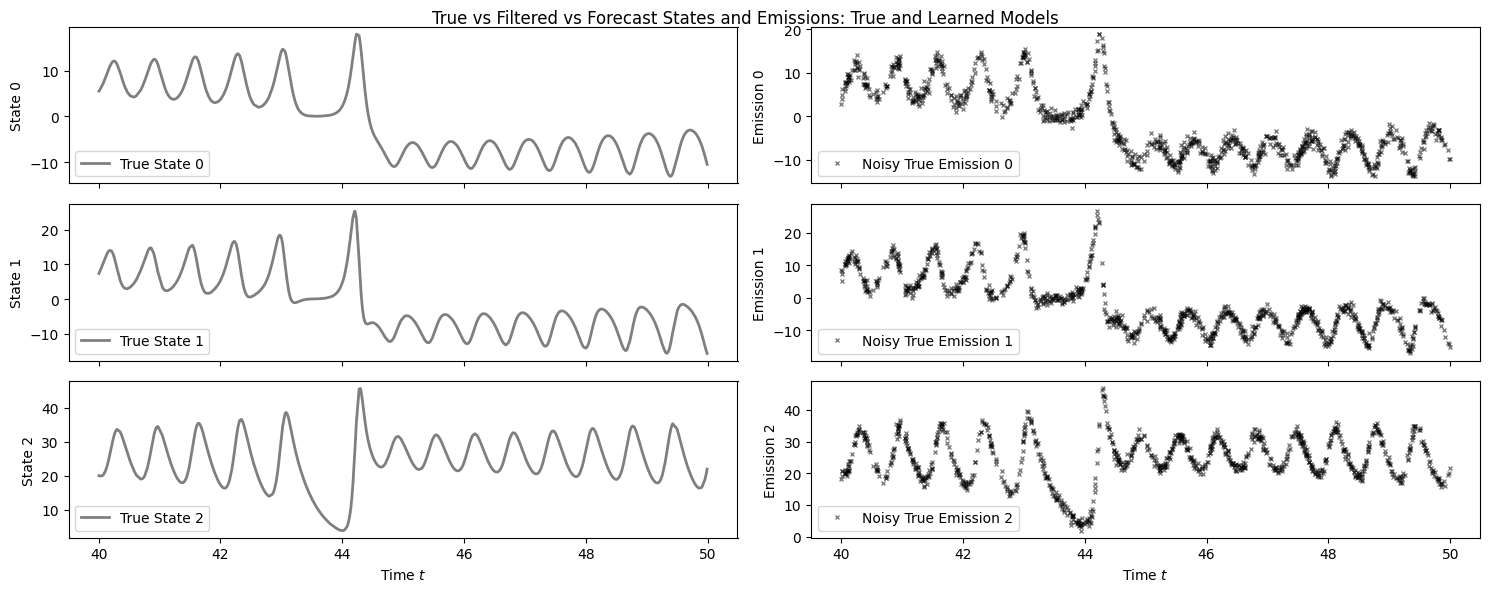

In [11]:
# Plot all the training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function
)

# Plot the filtering training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function,
    t_start=0,
    t_end=T_filter
)

# Plot the forecasting training data
plot_advanced2(
    time_grid_all=t_emissions_train,
    true_states=true_states_train,
    true_emissions_noisy=true_emissions_train,
    emission_function=true_params.emissions.emission_function,
    t_start=T_filter,
    t_end=T_total
)

# Parameter learning

### We start by defining a new model that is learnable

- We want to learn a model that might or might not be within the same function class of the data-generating mechanism

- The learnable model will be a ContDiscreteNonlinearGaussianSSM

- Here, we define the same model family as the data-generating model
    - i.e., the model family class is the same

- However:
    - the dynamics drift function will not-initialized to true values, and will be learnable
    - The rest of the model components will NOT be learnable

### CODE hint

- By default, all ParamProperties are set to trainable=True

- So, make sure you EXPLICITLY set trainable=False for all parameters you DO NOT want to learn/infer

In [12]:
## Main settings
state_dim = 3
emission_dim = 3

# The only learnable parameters are those in the learnable_drift
# An initial guess that is close to the true parameters
drift_parameter_guess = true_l63_drift_params + 0.1 * jr.normal(next(keys), (len(true_l63_drift_params),))

# Define the learnable drift model, with initial guess
learnable_drift = {
    "params": lorenz63_drift(params=drift_parameter_guess),
    "props": lorenz63_drift(params=ParameterProperties()),
}

## All parameters below are NOT learnable
learnable_diffusion_cov = {
    "params": LearnableMatrix(
        params=jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# The diffusion coefficient is fixed to non-learnable identity
learnable_diffusion_coefficient = {
    "params": LearnableMatrix(
        params=true_diffusion_coefficient_param * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(trainable=False)
    ),
}

# The emission function is fixed to non-learnable identity
learnable_emission = {
    "params": LearnableLinear(
        weights=H,
        bias=jnp.zeros(emission_dim)
    ),
    "props": LearnableLinear(
        weights=ParameterProperties(trainable=False),
        bias=ParameterProperties(trainable=False)
    ),
}

# The emission covariance is fixed to non-learnable identity
learnable_emission_cov = {
    "params": LearnableMatrix(
        params=R
    ),
    "props": LearnableMatrix(
        params=ParameterProperties(
            trainable=False,
            constrainer=RealToPSDBijector()
        )
    ),
}

# Define the initial mean and covariance
learnable_initial_mean = {
    "params": LearnableVector(
        params=jnp.zeros(state_dim)
    ),
    "props": LearnableVector(
        params=ParameterProperties(trainable=False)
    ),
}

learnable_initial_cov = {
    "params": LearnableMatrix(
        params=10.0 * jnp.eye(state_dim)
    ),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False, constrainer=RealToPSDBijector())),
}

# Concatenate all parameters in dictionary, for later easy use
all_learnable_params = {
    "initial_mean": learnable_initial_mean,
    "initial_cov": learnable_initial_cov,
    "dynamics_drift": learnable_drift,
    "dynamics_diffusion_coefficient": learnable_diffusion_coefficient,
    "dynamics_diffusion_cov": learnable_diffusion_cov,
    "dynamics_approx_order": 2.,  # Check on this later
    "emission_function": learnable_emission,
    "emission_cov": learnable_emission_cov,
}

### Define, instantiate and initialize the learnable model

In [13]:
# Create CD-NLGSSM model
learnable_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
initial_learnable_params, learnable_props = learnable_model.initialize(
    next(keys),
    **all_learnable_params
)

# Frequentist parameter estimation: Maximum likelihood estimates MLE


## Maximum likelihood parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

- MLE based on SGD over marginalized log-probability
- We will use Extended Kalman Filtering to compute the marginal log probability
    - Note that other options (EnKF and UKF) are implemented and can be readily used

### Define the filter to use to compute the marginalized log-likelihood

In [14]:
# Filter: EKF
from continuous_discrete_nonlinear_gaussian_ssm import EKFHyperParams
filter_hyperparams = EKFHyperParams()

### Define the SGD optimizer to use

In [15]:
# Build an optimizer
import optax
my_optimizer = optax.adam(1e-3) # maybe fancier if needed

# SGD optimizer related parameters
num_epochs = 100

### Fit the learnable model, using SGD to observed data, using the EKF filter to marginalize the latent states

In [16]:
# Fit test_model by running SGD, with EKF filter
fitted_params, neg_marginal_lls = learnable_model.fit_sgd(
    initial_learnable_params,
    learnable_props,
    true_emissions_train,
    t_emissions=t_emissions_train,
    filter_hyperparams=filter_hyperparams,
    optimizer=my_optimizer,
    num_epochs=num_epochs,
)

# Note that fit_sgd returns normalized negative log-likelihoods
# So we multiply it by the number of datapoints in emissions
marginal_lls = -neg_marginal_lls * true_emissions_train.size

### Plotting learning evolution

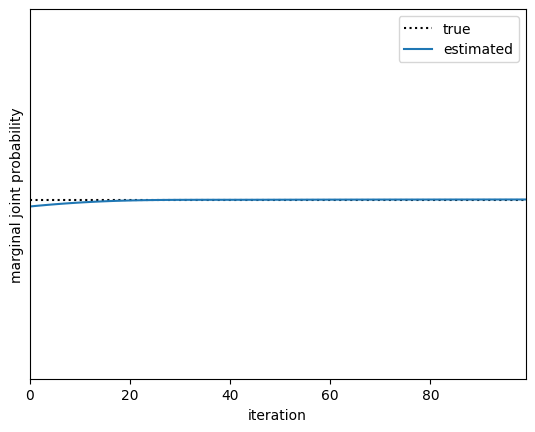

In [17]:
from sgd_plotting import plot_learning_curve
plot_learning_curve(
    marginal_lls,
    true_model,
    true_params,
    learnable_model,
    fitted_params,
    true_emissions_train,
    t_emissions_train,
)

## Evaluate learned MLE model

### Run EKF filtering on training data using learned MLE model

In [18]:
filtered_trainset_sgd, forecasted_trainset_sgd, \
    start_idx_filter, stop_idx_filter, \
        start_idx_forecast, stop_idx_forecast = \
            filter_and_forecast(
                model_params=fitted_params,
                filter_hyperparams=filter_hyperparams,
                t_emissions=t_emissions_train,
                emissions=true_emissions_train,
                T0=5,
                T_filter_end=25,
                T_forecast_end=45,
            )

### Plot performance of filtering and forecasting on training data

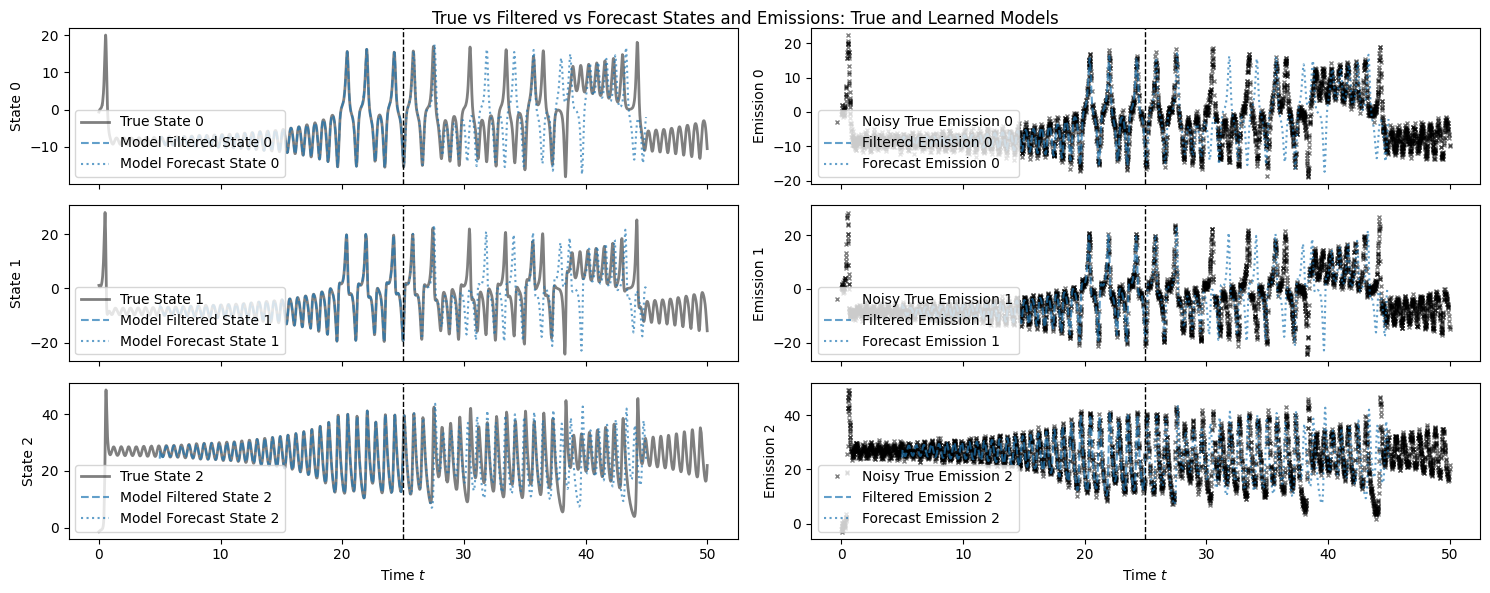

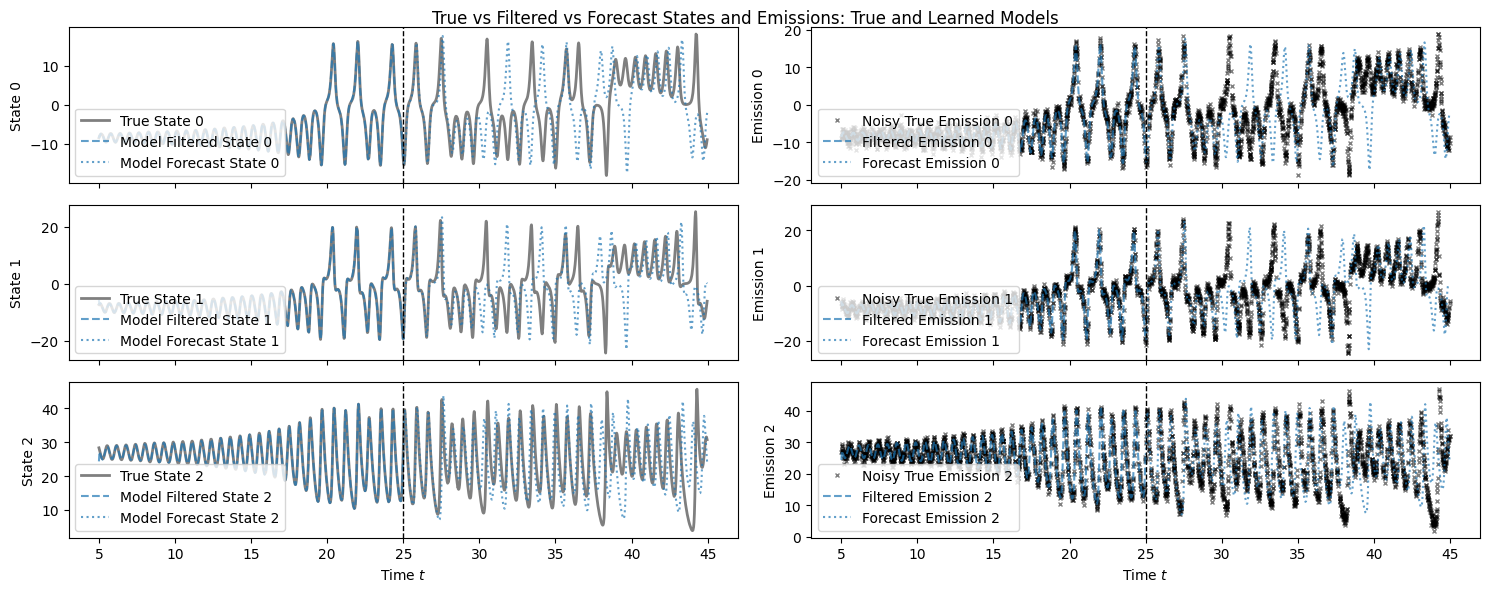

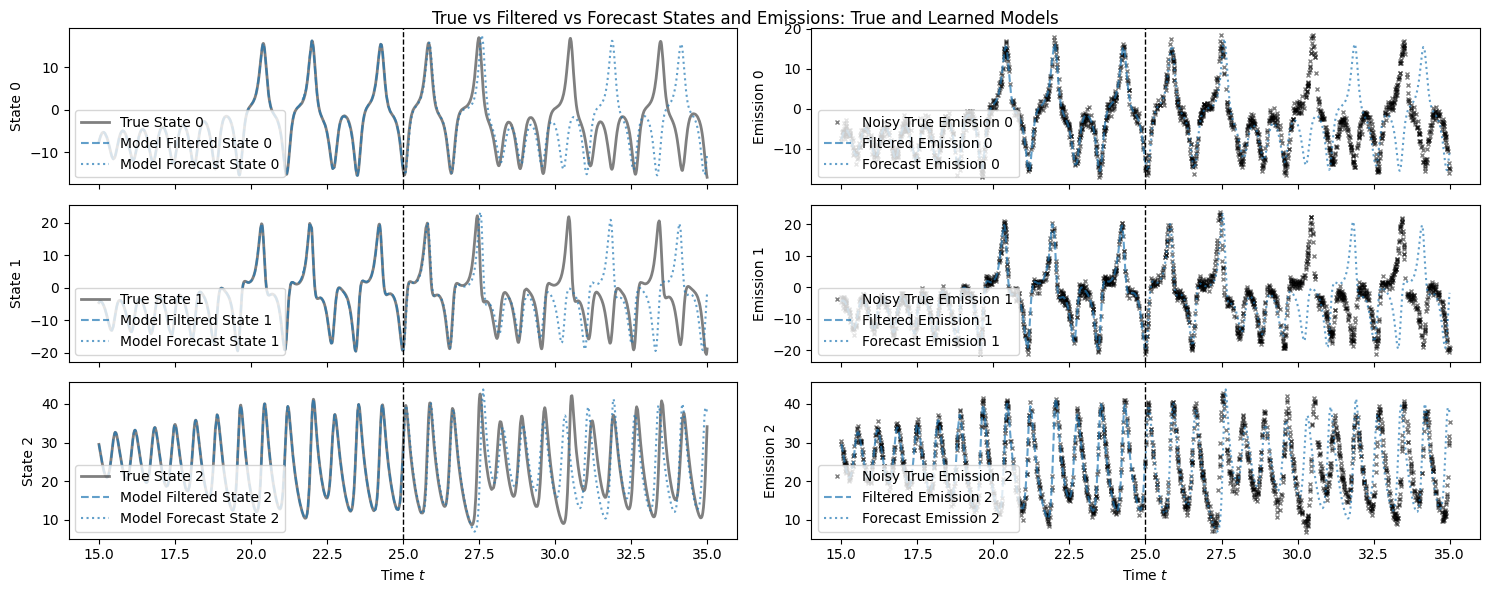

In [20]:
# Plot the true states and emissions, and the EKF estimates
# TODO: it might be useful to have time-points based on previous T_filter_end and T_forecast_end
for t_start, t_end in [(None, None), (5, 45), (15, 35)]:
    plot_advanced2(
        time_grid_all=t_emissions_train,
        true_states=true_states_train,
        true_emissions_noisy=true_emissions_train,
        emission_function=fitted_params.emissions.emission_function.f,
        time_grid_filter=t_emissions_train[start_idx_filter:stop_idx_filter],
        model_filtered_states=filtered_trainset_sgd.filtered_means,
        model_filtered_covariances=filtered_trainset_sgd.filtered_covariances,
        time_grid_forecast=t_emissions_train[start_idx_forecast:stop_idx_forecast],
        model_forecast_states=forecasted_trainset_sgd.forecasted_state_means,
        # model_forecast_covariances=forecasted_testset_sgd.forecasted_state_covariances,
        t_start=t_start,
        t_end=t_end,
    )

### Run EKF filtering on testing data using learned MLE model

In [21]:
filtered_testset_sgd, forecasted_testset_sgd, \
    start_idx_filter, stop_idx_filter, \
        start_idx_forecast, stop_idx_forecast = \
            filter_and_forecast(
                model_params=fitted_params,
                filter_hyperparams=filter_hyperparams,
                t_emissions=t_emissions_test,
                emissions=true_emissions_test,
                T0=5,
                T_filter_end=25,
                T_forecast_end=45,
            )

### Plot performance of filtering and forecasting on testing data

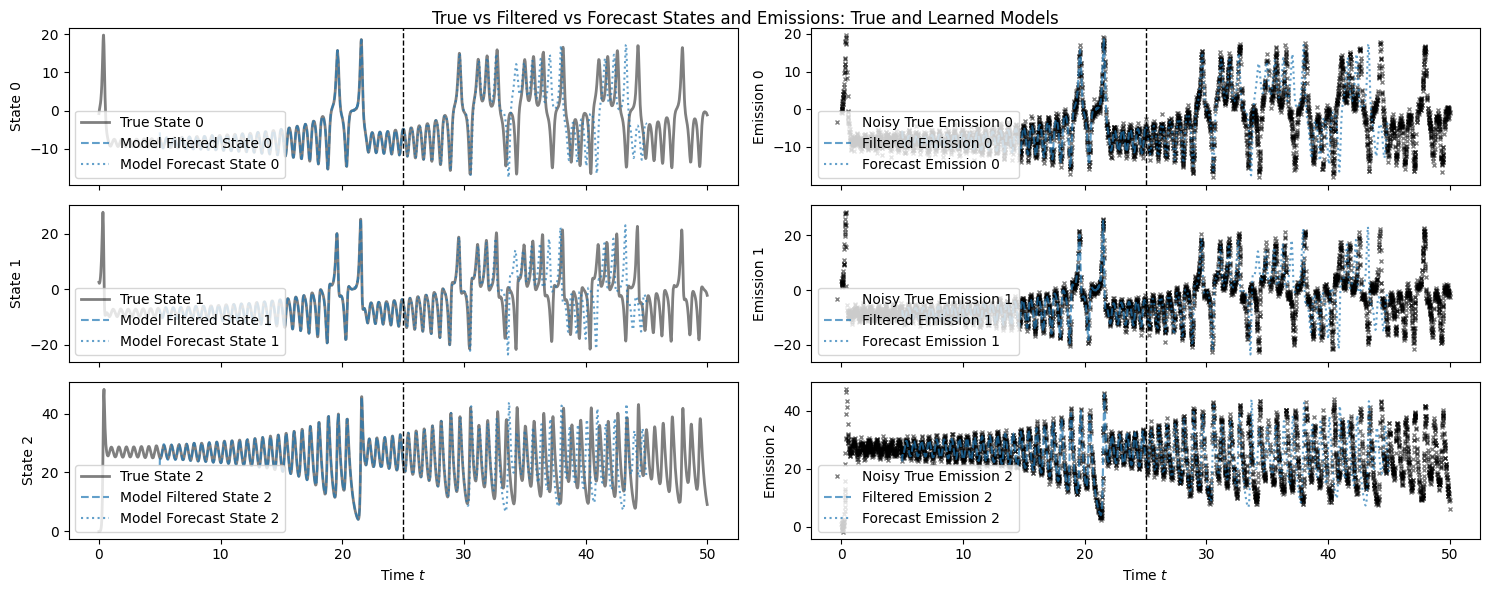

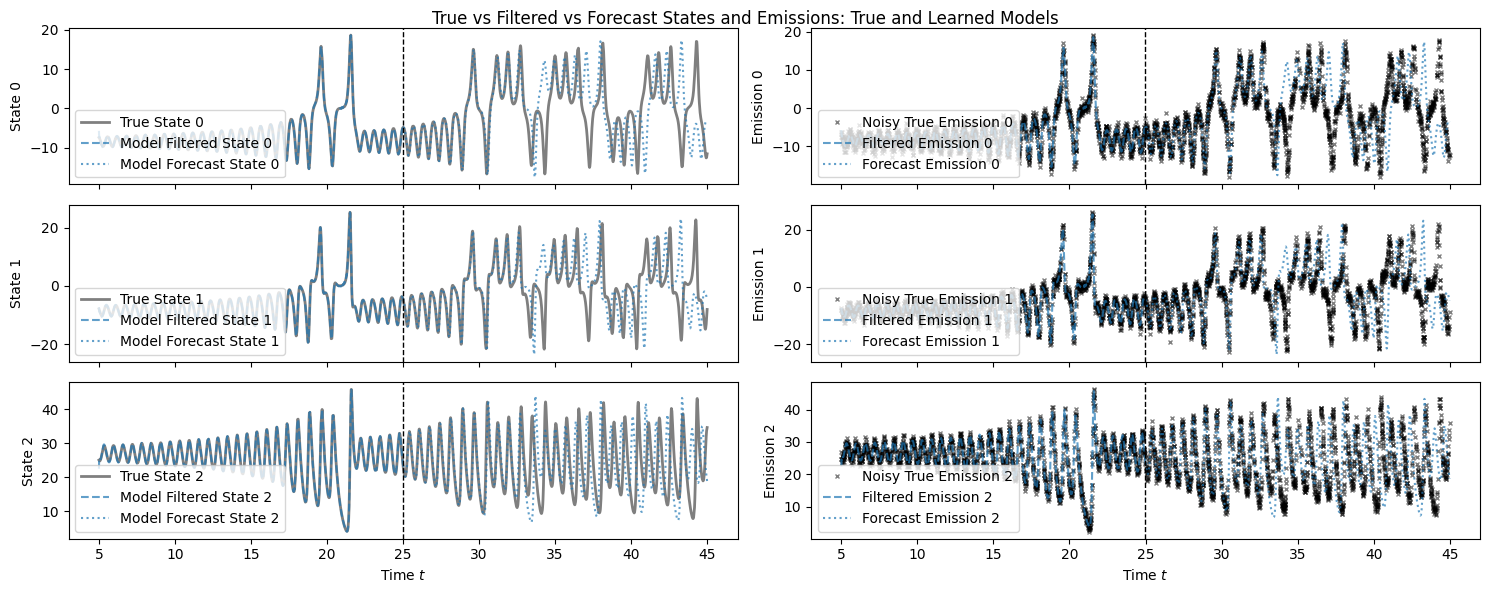

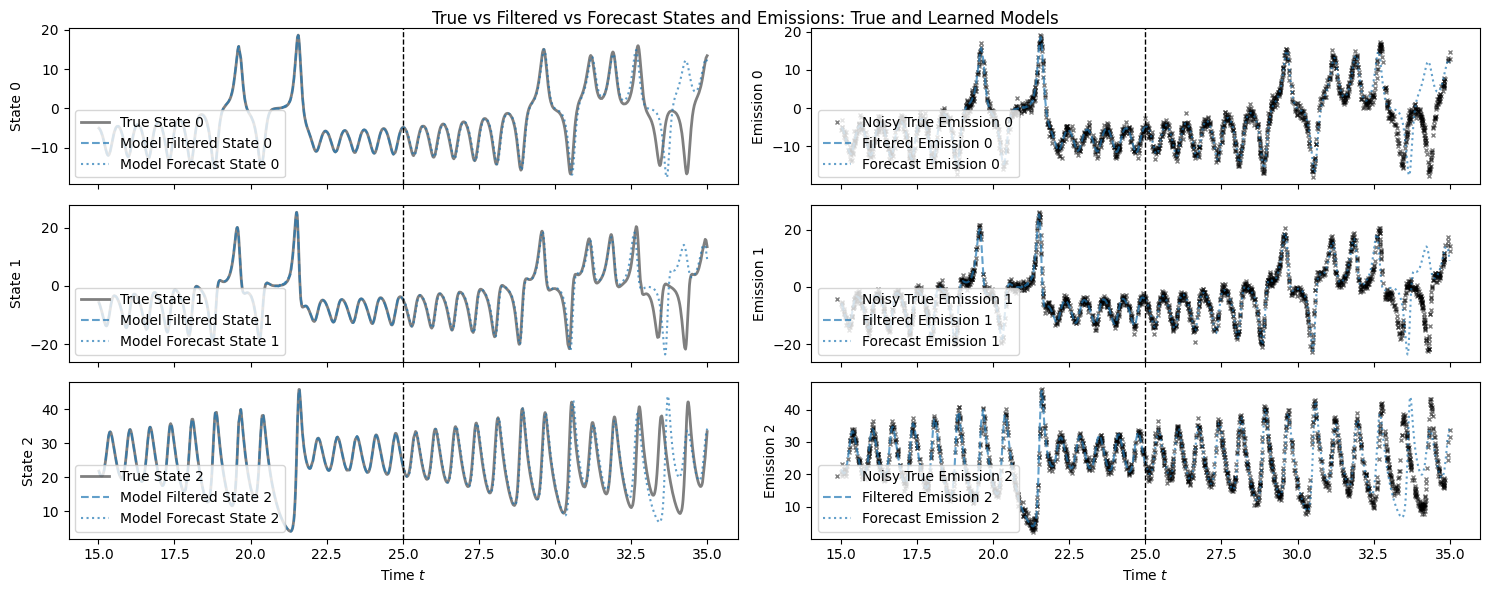

In [22]:
# Plot the true states and emissions, and the EKF estimates
# TODO: it might be useful to have time-points based on previous T_filter_end and T_forecast_end
for t_start, t_end in [(None, None), (5, 45), (15, 35)]:
    plot_advanced2(
        time_grid_all=t_emissions_test,
        true_states=true_states_test,
        true_emissions_noisy=true_emissions_test,
        emission_function=fitted_params.emissions.emission_function.f,
        time_grid_filter=t_emissions_test[start_idx_filter:stop_idx_filter],
        model_filtered_states=filtered_testset_sgd.filtered_means,
        model_filtered_covariances=filtered_testset_sgd.filtered_covariances,
        time_grid_forecast=t_emissions_test[start_idx_forecast:stop_idx_forecast],
        model_forecast_states=forecasted_testset_sgd.forecasted_state_means,
        # model_forecast_covariances=forecasted_testset_sgd.forecasted_state_covariances,
        t_start=t_start,
        t_end=t_end,
    )

# Bayesian parameter estimation: Maximum A-Posteriori (MAP) estimates

## Bayesian parameter estimation for an irregularly-sampled, continuous-discrete (non-linear) Gaussian dynamical system

### HMC w/ autodifferentiable filtering

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the HMC-based parameter posterior $p(\theta|y(1:T))$ for a nonlinear dynamical model.

    - TODO: Showcase how to use NUTS

We use the Extended Kalman filter to compute the marginal likelihood, $p(y(1:T) | \theta) = \int_{z(1:T)} p(z(1:T), y(1:T)|\theta)$.


### Model MAP learning, based on HMC
- We will use Extended Kalman Filtering to compute the marginal log probability, for SGD to optimize

In [23]:
# Filter: EKF
hmc_filter_hyperparams = EKFHyperParams()

### HMC hyperparameters and initialization

In [24]:
# HMC hyperparameters
hmc_samples = 100
hmc_warmup = 100
hmc_integration_steps=30

In [ ]:
# HMC is initialized at random parameters
# Run
param_samples, lps = learnable_model.fit_hmc(
    initial_learnable_params,
    learnable_props,
    true_emissions_train,
    t_emissions=t_emissions_train,
    filter_hyperparams=hmc_filter_hyperparams,
    num_samples=hmc_samples,
    warmup_steps=hmc_warmup,
    num_integration_steps=hmc_integration_steps,
)

### Visualize the sequence of log-probabilities during the MCMC run

In [ ]:
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

In [22]:
# TODO: IU feels this should be more automated, with vmap
# Why define wrapper functions for the filter_and_forecast function?
def filter_and_forecast_wrapper(params):
    filtered, forecasted, start_idx_filter, stop_idx_filter, start_idx_forecast, stop_idx_forecast = (
        filter_and_forecast(
            t_emissions,
            true_emissions,
            params,
            T0=5,
            T_filter_end=25,
            T_forecast_end=45,
        )
    )
    return (
        filtered,
        forecasted,
        start_idx_filter,
        stop_idx_filter,
        start_idx_forecast,
        stop_idx_forecast,
    )


# Vectorize the wrapper function with vmap
batched_filter_and_forecast = jax.vmap(filter_and_forecast_wrapper)

# Apply the vectorized function to the batched params
(
    filtered_trainset_hmc,
    forecasted_trainset_hmc,
    start_idx_filter_hmc,
    stop_idx_filter_hmc,
    start_idx_forecast_hmc,
    stop_idx_forecast_hmc,
) = batched_filter_and_forecast(param_samples)

start_idx_filter_hmc = start_idx_filter_hmc[0]
stop_idx_filter_hmc = stop_idx_filter_hmc[0]
start_idx_forecast_hmc = start_idx_forecast_hmc[0]
stop_idx_forecast_hmc = stop_idx_forecast_hmc[0]

# IU got lost here, need to check
def split_params(params, index):
    """Extracts the specific index from each parameter in the structure."""
    return jax.tree_map(lambda x: x[index], params)
emission_function_list = [split_params(param_samples.emissions.emission_function, i) for i in range(hmc_samples)]
# now extract the .f function from each of the emission functions
emission_function_f_list = [x.f for x in emission_function_list]

In [ ]:
# Plot the true states and emissions, and the EKF estimates
for t_start, t_end in [(None, None), (5, 45), (15, 35)]:
    plot_advanced2(
        time_grid_all=t_emissions,
        true_states=true_states,
        true_emissions_noisy=true_emissions,
        emission_function=emission_function_f_list,
        time_grid_filter=t_emissions[start_idx_filter_hmc:stop_idx_filter_hmc],
        model_filtered_states=filtered_trainset_hmc.filtered_means,
        model_filtered_covariances=filtered_trainset_hmc.filtered_covariances,
        time_grid_forecast=t_emissions[start_idx_forecast_hmc:stop_idx_forecast_hmc],
        model_forecast_states=forecasted_trainset_hmc.forecasted_state_means,
        # model_forecast_covariances=forecasted_testset_sgd.forecasted_state_covariances,
        t_start=t_start,
        t_end=t_end,
        N_samples=hmc_samples,
    )

In [ ]:
plot_all(param_samples)

### SGD initialized HMC

In [ ]:
# Now, run HMC initialized at the SGD-fitted parameters
param_samples, lps = learnable_model.fit_hmc(
    fitted_params,
    learnable_props,
    true_emissions_train,
    t_emissions=t_emissions_train,
    filter_hyperparams=hmc_filter_hyperparams,
    num_samples=hmc_samples,
    warmup_steps=hmc_warmup,
    num_integration_steps=hmc_integration_steps,
)

In [ ]:
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

In [27]:
# IU: why define all this again?
def filter_and_forecast_wrapper(params):
    filtered, forecasted, start_idx_filter, stop_idx_filter, start_idx_forecast, stop_idx_forecast = (
        filter_and_forecast(
            t_emissions,
            true_emissions,
            params,
            T0=5,
            T_filter_end=25,
            T_forecast_end=45,
        )
    )
    return (
        filtered,
        forecasted,
        start_idx_filter,
        stop_idx_filter,
        start_idx_forecast,
        stop_idx_forecast,
    )


# Vectorize the wrapper function with vmap
batched_filter_and_forecast = jax.vmap(filter_and_forecast_wrapper)

# Apply the vectorized function to the batched params
(
    filtered_trainset_hmc,
    forecasted_trainset_hmc,
    start_idx_filter_hmc,
    stop_idx_filter_hmc,
    start_idx_forecast_hmc,
    stop_idx_forecast_hmc,
) = batched_filter_and_forecast(param_samples)

start_idx_filter_hmc = start_idx_filter_hmc[0]
stop_idx_filter_hmc = stop_idx_filter_hmc[0]
start_idx_forecast_hmc = start_idx_forecast_hmc[0]
stop_idx_forecast_hmc = stop_idx_forecast_hmc[0]


def split_params(params, index):
    """Extracts the specific index from each parameter in the structure."""
    return jax.tree_map(lambda x: x[index], params)

emission_function_list = [split_params(param_samples.emissions.emission_function, i) for i in range(hmc_samples)]
# now extract the .f function from each of the emission functions
emission_function_f_list = [x.f for x in emission_function_list]

In [ ]:
# Plot the true states and emissions, and the EKF estimates
for t_start, t_end in [(None, None), (5, 45), (15, 35)]:
    plot_advanced2(
        time_grid_all=t_emissions,
        true_states=true_states,
        true_emissions_noisy=true_emissions,
        emission_function=emission_function_f_list,
        time_grid_filter=t_emissions[start_idx_filter_hmc:stop_idx_filter_hmc],
        model_filtered_states=filtered_trainset_hmc.filtered_means,
        model_filtered_covariances=filtered_trainset_hmc.filtered_covariances,
        time_grid_forecast=t_emissions[start_idx_forecast_hmc:stop_idx_forecast_hmc],
        model_forecast_states=forecasted_trainset_hmc.forecasted_state_means,
        # model_forecast_covariances=forecasted_testset_sgd.forecasted_state_covariances,
        t_start=t_start,
        t_end=t_end,
        N_samples=hmc_samples,
    )

In [ ]:
plot_all(param_samples)